In [55]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA #this package doesn't work anymore and was switched to the one underneth
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima

In [56]:
POS = pd.read_csv('C:/Users/althy/Desktop/Graduation Project/Graduation_Project-main/POS_monthly_2023.csv',index_col='Date', parse_dates=True)

In [57]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [129]:
POS.head(5)

,Total
Date,
Jan-15,32156481.0
Feb-15,29603197.0
Mar-15,32793427.0
Apr-15,30356911.0
May-15,33099974.0


In [93]:
POS.describe()

,Total
count,9.700000e+01
mean,2.088249e+08
std,2.062546e+08
min,2.960320e+07
25%,5.215320e+07
50%,1.063572e+08
75%,3.465955e+08
max,6.919239e+08


In [60]:
#checking for Nan values
POS.isna().values.any()

True

In [61]:
POS[POS.index.isna()]

,Total
Date,


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [62]:
clean_POS = POS.dropna()

In [63]:
#checking for duplicated in date column.
clean_POS.index.duplicated().any()

False

C:\Users\althy\AppData\Local\Temp\ipykernel_11204\3259346624.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x="Date", y="Total",


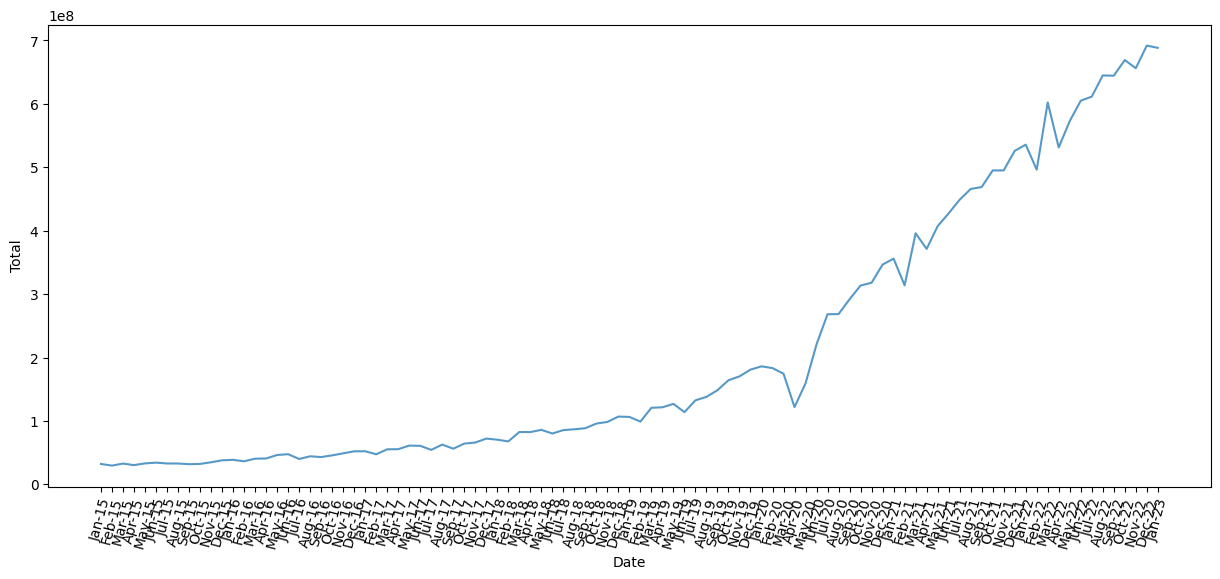

In [64]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 6)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
plt.show()

<h3> Testing stationary

In [65]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
    
    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

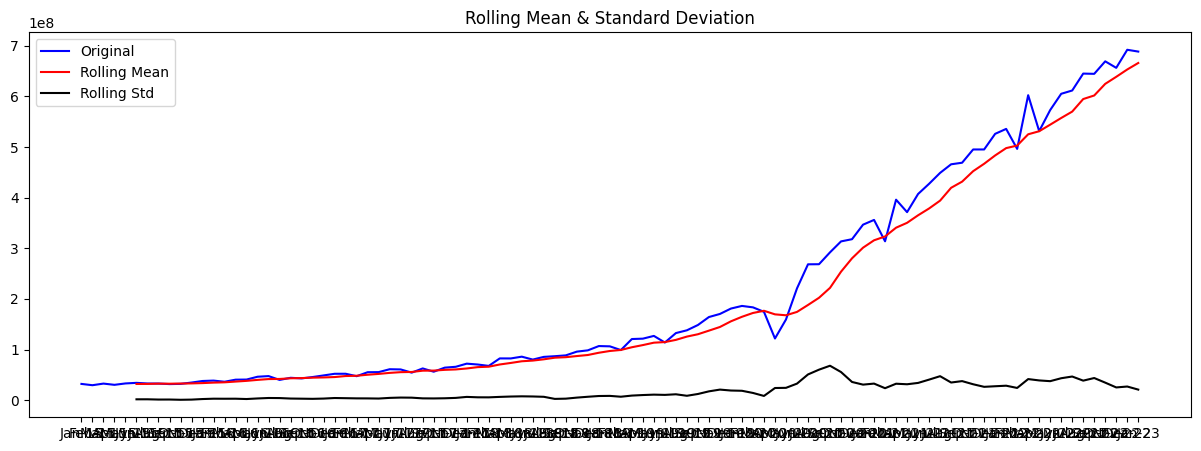

Results of Dickey Fuller Test:
Test Statistic                 -0.420112
p-value                         0.906686
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [67]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

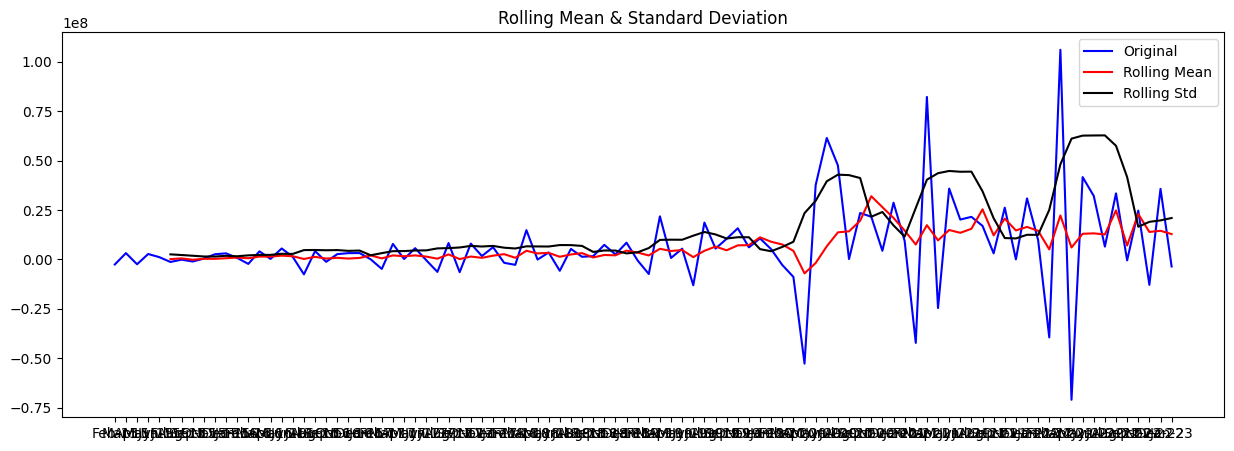

Results of Dickey Fuller Test:
Test Statistic                 -1.188642
p-value                         0.678463
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [68]:
clean_POS_diff = clean_POS.diff().dropna()
test_stationarity(clean_POS_diff)

<h5> p-value still high, so we will transform the data again by taking the log <h5>

In [135]:
clean_POS_diff_log = pd.DataFrame(np.log(clean_POS_diff)).dropna()

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


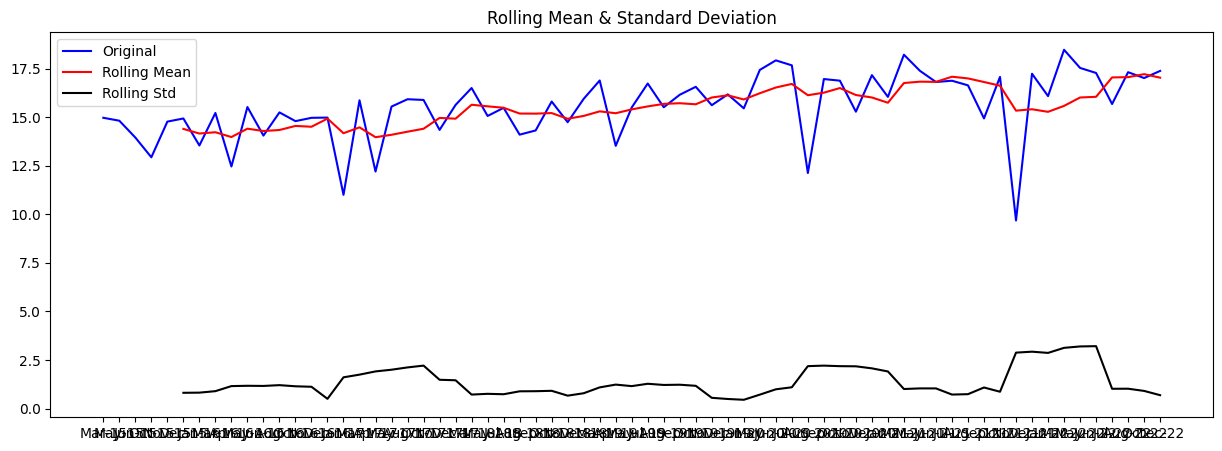

Results of Dickey Fuller Test:
Test Statistic                 -3.590851
p-value                         0.005938
#Lags Used                      1.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [136]:
test_stationarity(clean_POS_diff_log.dropna())

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


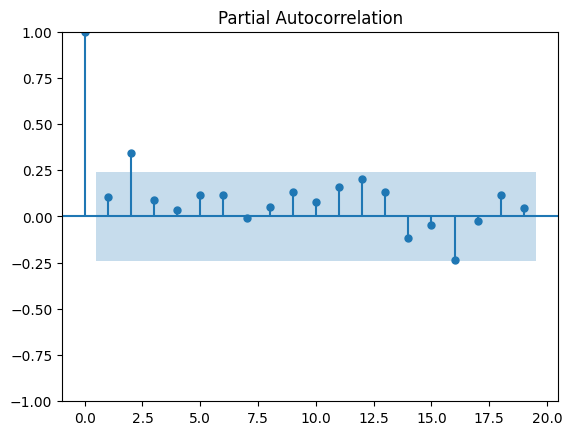

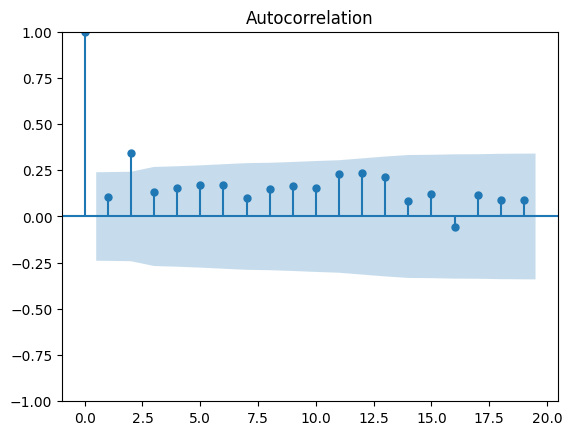

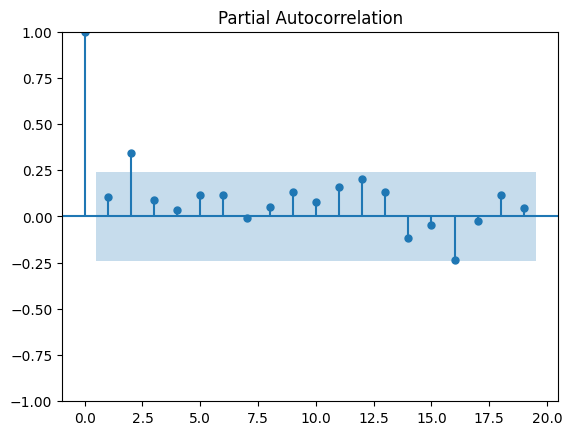

In [137]:
plot_acf(clean_POS_diff_log.dropna())
plot_pacf(clean_POS_diff_log.dropna())

<h4> from the ACF and PACF we conclude that ARIMA model is (1,2,1)<h4>
<h4> to make sure that I have the best model, I'll test it against diffrent models using AIC and BIC

In [72]:
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

In [138]:
model = ARIMA(clean_POS_diff_log, order=(1,2,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   67
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -131.295
Date:                Fri, 10 Mar 2023   AIC                            268.591
Time:                        03:36:07   BIC                            275.114
Sample:                             0   HQIC                           271.164
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6237      0.069     -8.998      0.000      -0.760      -0.488
ma.L1         -0.9998     16.133     -0.062      0.951     -32.620      30.621
sigma2         3.0508     49.091      0.062      0.9

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [74]:
assess_arima(ARIMA(clean_POS_diff_log, order=(0,2,1)).fit())

AIC = 324.52863556908096
BIC = 329.615225133621


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [75]:
assess_arima(ARIMA(clean_POS_diff_log, order=(1,2,0)).fit())

AIC = 356.3145854598675
BIC = 361.4011750244075


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [76]:
assess_arima(ARIMA(clean_POS_diff_log, order=(2,2,0)).fit())

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC = 317.9684191124939
BIC = 325.5983034593039


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [77]:
assess_arima(ARIMA(clean_POS_diff_log, order=(2,2,2)).fit())

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\althy\App

AIC = 269.6108170015516
BIC = 282.3272909129016


In [79]:
another_model = assess_arima(ARIMA(clean_POS_diff_log, order=(0,2,2)).fit())

AIC = 267.95801901164623
BIC = 275.58790335845623


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<h5> from the result we find that ARIMA(0,2,2) has lower AIC and BIC, we will use it as alternative model, will make the train/test with both model 

In [98]:
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

In [140]:
int(0.80 * len(clean_POS_diff_log))

53

In [141]:
split_index = int(0.80 * len(clean_POS_diff_log))
train_data = clean_POS_diff_log.iloc[:split_index, :]
test_data = clean_POS_diff_log.iloc[split_index:, :]


In [160]:
model = ARIMA(train_data, order=(0,2,2)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: Length of values (20) does not match length of index (14)

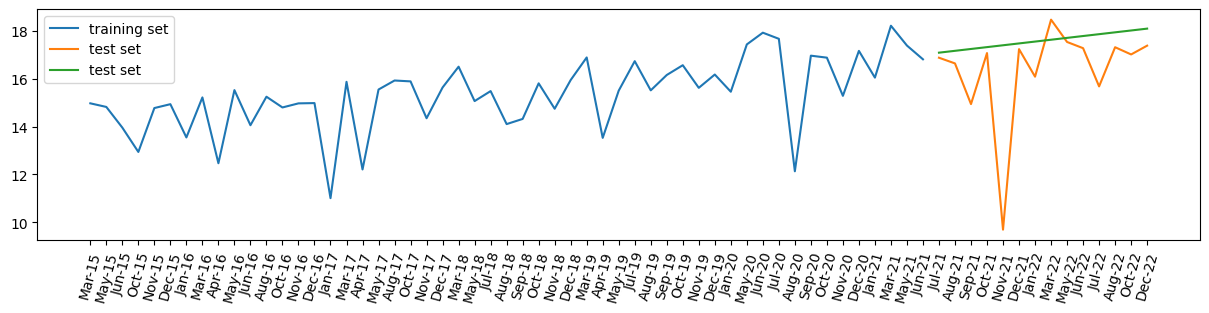

In [148]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(train_data.dropna(), label = 'training set')
plt.plot(test_data.dropna(), label='test set')
plt.plot(y_pred, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [150]:
forecast = y_pred.Total

In [151]:
forecast_unlog = np.exp(forecast)

In [152]:
last_value = test_data.dropna().Total[-1]
forecast_undiff = forecast_unlog.cumsum()+ last_value

In [156]:
forecast_undiff[0]

26601358.915736213

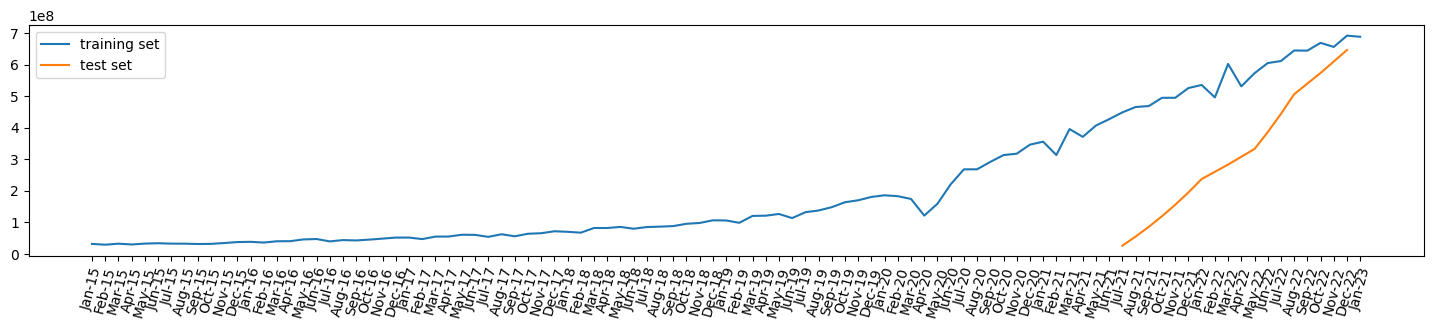

In [158]:
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.plot(clean_POS, label = 'training set')
plt.plot(forecast_undiff , label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [155]:
clean_POS

,Total
Date,
Jan-15,32156481.0
Feb-15,29603197.0
Mar-15,32793427.0
Apr-15,30356911.0
May-15,33099974.0
...,...
Sep-22,644414261.0
Oct-22,669108839.0
Nov-22,656246635.0
